In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
from datetime import datetime

# TESTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import train_test_split

# DEPENDENCIES FOR LINEAR REGRESSION MODEL
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

### FUNCTIONS

In [3]:
def plot_forecast_vs_actual(
    train_df: pd.DataFrame,
    actual_df: pd.DataFrame,
    forecast,  # array-like or pd.Series
    column: str = 'ImbalancePriceEUR',
    period_label: str = '',
    model_order: str = ''
):
    """
    Plots forecasted vs actual values for a given column, including the
    last 48 hours from the training data.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data (must contain `column`).
    actual_df : pd.DataFrame
        Test data (must contain `column`) with a DatetimeIndex.
    forecast : array-like or pd.Series
        Forecast values corresponding one-to-one with `actual_df.index`.
    column : str
        Name of the target column to plot.
    period_label : str
        Text to include in the title (e.g. the period string).
    model_order : str
        Model identifier for the title.
    """
    # 1) Extract actual and training series
    actual_series = actual_df[column]
    train_series  = train_df[column].iloc[-48:]  # last 48 hours
    
    # 2) Build forecast_series with the same index as actual_df
    if isinstance(forecast, pd.Series):
        # preserve name and index
        forecast_series = forecast.copy()
    else:
        # assume array-like: align to actual_df.index
        forecast_series = pd.Series(
            data=forecast,
            index=actual_df.index,
            name=column
        )

    # 3) Align them in case of any mismatch
    common_idx = train_series.index.union(actual_series.index).union(forecast_series.index)
    # but we only need where forecast & actual overlap
    common_idx = forecast_series.index.intersection(actual_series.index)
    actual_series   = actual_series.loc[common_idx]
    forecast_series = forecast_series.loc[common_idx]

    # 4) Plot
    plt.figure(figsize=(12, 5))
    plt.plot(
        train_series.index, train_series.values,
        label='Training (last 48h)',
        linestyle='-.',
        alpha=0.8
    )
    plt.plot(
        actual_series.index, actual_series.values,
        label='Actual', marker='o', linestyle='-'
    )
    plt.plot(
        forecast_series.index, forecast_series.values,
        label='Forecast', marker='x', linestyle='--'
    )
    plt.title(f'Forecast vs Actual [ModelOrder: {model_order}] - {column} ({period_label})')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
def split_biweekly_train_test(df: pd.DataFrame) -> dict:
    biweekly_data = {'period': [], 'train': [], 'test': []}

    start = df.index.min()
    end   = df.index.max()
    current = start

    while current + pd.Timedelta(days=14) <= end:
        train_start = current
        train_end   = current + pd.Timedelta(days=14) - pd.Timedelta(hours=1)

        test_start = train_end + pd.Timedelta(hours=1)
        test_end   = test_start + pd.Timedelta(hours=23)

        # slice train; guaranteed to be within bounds
        train_df = df.loc[train_start:train_end]

        # slice test; guard against going past the dataset end
        if test_end <= end:
            test_df = df.loc[test_start:test_end]
        else:
            print(f"WARNING: Incomplete test window for period starting {train_start.date()}")
            test_df = pd.DataFrame(columns=df.columns)

        period_label = f"{train_start.date()}_to_{train_end.date()}"

        biweekly_data['period'].append(period_label)
        biweekly_data['train'].append(train_df)
        biweekly_data['test'].append(test_df)

        # advance window by exactly 14 days
        current += pd.Timedelta(days=14)

    # print summary
    total = len(biweekly_data['period'])
    print("Total periods:", total)
    for i, period in enumerate(biweekly_data['period']):
        n_train = len(biweekly_data['train'][i])
        n_test  = len(biweekly_data['test'][i])
        print(f"{period}: Train = {n_train}, Test = {n_test}")

    return biweekly_data


In [5]:
def split_monthly_train_test(df: pd.DataFrame) -> dict:
    """
    Splits an hourly-indexed DataFrame into monthly train/test sets.
    
    - For December: train = first 30 days, test = last day (24h)
    - For other months: train = full month, test = next 24h (if available)
    
    Prints:
      - Total number of periods processed
      - For each period, the lengths of train and test sets.
    
    Returns:
      {
        'period': [ '2024-01', '2024-02', … ],
        'train':  [ train_df_for_2024-01, … ],
        'test':   [ test_df_for_2024-01, … ]
      }
    """
    monthly_data = {'period': [], 'train': [], 'test': []}

    # Group by month period
    for period, group in df.groupby(df.index.to_period('M')):
        month_df = group.sort_index()
        start = month_df.index[0]
        end   = month_df.index[-1]

        if start.month == 12:
            # December: first 30 days → train; last day → test
            train_end  = start + pd.Timedelta(days=30)
            train_df   = month_df.loc[start : train_end - pd.Timedelta(hours=1)]
            test_start = train_end
            test_end   = test_start + pd.Timedelta(hours=23)
            test_df    = month_df.loc[test_start : test_end]
        else:
            # Other months: train = full month; test = next 24h in the overall df
            train_df = month_df
            try:
                # find the very next timestamp after this month's last hour
                idx       = df.index.get_loc(end) + 1
                test_df   = df.iloc[idx : idx + 24]
            except (IndexError, KeyError):
                # not enough data to form a 24h test set
                print(f"WARNING: Could not build test set for period {period}")
                test_df = pd.DataFrame(columns=df.columns)

        monthly_data['period'].append(str(period))
        monthly_data['train'].append(train_df)
        monthly_data['test'].append(test_df)

    # Print summary
    total = len(monthly_data['period'])
    print("Total periods:", total)
    for i in range(total):
        p = monthly_data['period'][i]
        n_train = len(monthly_data['train'][i])
        n_test  = len(monthly_data['test'][i])
        print(f"{p}: Train = {n_train}, Test = {n_test}")

    return monthly_data


In [6]:
def split_quarterly_train_test(df: pd.DataFrame) -> dict:
    quarterly_data = {'period': [], 'train': [], 'test': []}

    # Group the DataFrame by quarter
    for period, group in df.groupby(df.index.to_period('Q')):
        q_df = group.sort_index()
        start = q_df.index[0]
        end   = q_df.index[-1]

        if start.month == 10:
            # Q4: last 24h of quarter as test
            train_df = q_df.loc[start : end - pd.Timedelta(hours=24)]
            test_df  = q_df.loc[end - pd.Timedelta(hours=23) : end]
        else:
            # Other quarters: first 24h after quarter end as test
            train_df = q_df
            next_start = end + pd.Timedelta(hours=1)
            test_end   = next_start + pd.Timedelta(hours=23)
            if test_end <= df.index.max():
                test_df = df.loc[next_start : test_end]
            else:
                print(f"WARNING: Incomplete test window for period {period}")
                test_df = pd.DataFrame(columns=df.columns)

        quarterly_data['period'].append(str(period))
        quarterly_data['train'].append(train_df)
        quarterly_data['test'].append(test_df)

    # Print summary
    total = len(quarterly_data['period'])
    print("Total periods:", total)
    for i, period in enumerate(quarterly_data['period']):
        n_train = len(quarterly_data['train'][i])
        n_test  = len(quarterly_data['test'][i])
        print(f"{period}: Train = {n_train}, Test = {n_test}")

    return quarterly_data


In [7]:
def clean_and_interpolate_hourly(df, verbose=True):
    """
    Cleans a time-indexed DataFrame by:
    - Dropping NaNs
    - Removing duplicate timestamps via averaging
    - Reindexing to ensure full hourly range
    - Interpolating missing values

    Parameters:
    - df (pd.DataFrame): Time-indexed DataFrame
    - verbose (bool): Whether to print status updates

    Returns:
    - pd.DataFrame: Cleaned and interpolated DataFrame
    """
    df_clean = df.dropna()
    if verbose:
        print(df_clean.columns, df_clean.shape)

        duplicates_before = df_clean.index.duplicated().sum()
        print(f"Number of duplicate timestamps BEFORE: {duplicates_before}")

    # Resolve duplicates by averaging
    df_clean = df_clean.groupby(df_clean.index).mean()

    if verbose:
        duplicates_after = df_clean.index.duplicated().sum()
        print(f"Number of duplicate timestamps AFTER: {duplicates_after}\n")

    # Create expected hourly index
    expected_index = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='h')
    missing = expected_index.difference(df_clean.index)
    if verbose:
        print(f"Number of missing hourly timestamps BEFORE: {len(missing)}")
        if len(missing) > 0:
            print(missing[:10])  # Show first 10

    # Reindex and interpolate
    df_clean = df_clean.reindex(expected_index)
    df_clean = df_clean.interpolate(method='time')

    missing_after = expected_index.difference(df_clean.index)
    if verbose:
        print(f"Number of missing hourly timestamps AFTER: {len(missing_after)}")
        if len(missing_after) > 0:
            print(missing_after[:10])

    return df_clean


In [8]:
def metrics_plot(metrics_dict):
    periods = list(metrics_dict.keys())
    mae   = [metrics_dict[p]['MAE']  for p in periods]
    mse   = [metrics_dict[p]['MSE']  for p in periods]
    rmse  = [metrics_dict[p]['RMSE'] for p in periods]
    r2    = [metrics_dict[p]['R2']   for p in periods]
    mpe   = [metrics_dict[p]['MPE']  for p in periods]

    # ---- Combined MAE & RMSE ----
    plt.figure(figsize=(10,5))
    plt.plot(periods, mae,  marker='o', linestyle='-',  label='MAE')
    plt.plot(periods, rmse, marker='^', linestyle='-.', label='RMSE')
    for i, (a, r) in enumerate(zip(mae, rmse)):
        plt.text(periods[i], a, f'{a:.2f}', ha='center', va='bottom', fontsize=8)
        plt.text(periods[i], r, f'{r:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Period')
    plt.ylabel('Error Value')
    plt.title('MAE & RMSE Over Periods')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- MPE Alone ----
    plt.figure(figsize=(10,4))
    plt.plot(periods, mpe, marker='s', linestyle='--', label='MPE')
    for i, v in enumerate(mpe):
        plt.text(periods[i], v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Period')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('MPE Over Periods')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- MSE Alone ----
    plt.figure(figsize=(10,4))
    plt.plot(periods, mse, marker='d', linestyle=':', label='MSE')
    for i, v in enumerate(mse):
        plt.text(periods[i], v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Period')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Over Periods')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- R² Alone ----
    plt.figure(figsize=(10,4))
    plt.plot(periods, r2, marker='D', linestyle='-', color='tab:purple', label='R²')
    for i, v in enumerate(r2):
        plt.text(periods[i], v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Period')
    plt.ylabel('R²')
    plt.title('R² Over Periods')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    # Compute MPE: average of (y_true - y_pred) / y_true, expressed in percent
    #mpe = 
    mpe = np.mean((y_true - y_pred) / y_true) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MPE': mpe
    }

In [10]:
def avg_metrics(metrics_dict):
    
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df.index.name = 'Period'
    
    # Compute means
    avg = df.mean()

    # Nicely print
    print("Average metrics across all periods:")
    for metric, value in avg.items():
        print(f"  {metric:<5} : {value:.4f}")
    
    # Return as plain dict
    return avg.to_dict()

# CODE

Index(['ImbalanceMWh', 'ImbalancePriceEUR', 'mFRR_UpPurchased',
       'mFRR_UpPriceEUR', 'SpotPriceEUR', 'FCRdomestic_MW', 'FCRdk_EUR'],
      dtype='object')
(8784, 7)


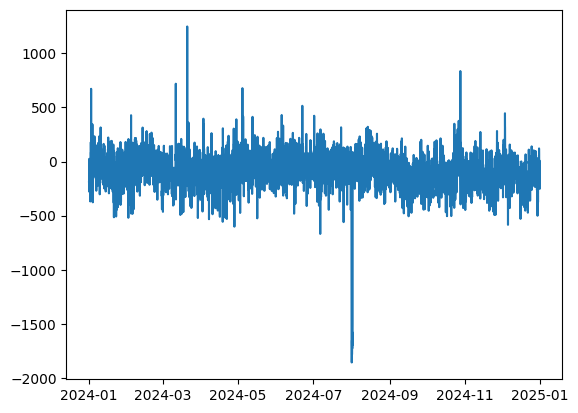

ImbalanceMWh: masking 174 outliers (1.98%)
ImbalancePriceEUR: masking 174 outliers (1.98%)
mFRR_UpPurchased: masking 0 outliers (0.00%)
mFRR_UpPriceEUR: masking 159 outliers (1.81%)
SpotPriceEUR: masking 175 outliers (1.99%)
FCRdomestic_MW: masking 132 outliers (1.50%)
FCRdk_EUR: masking 176 outliers (2.00%)
(8784, 7)


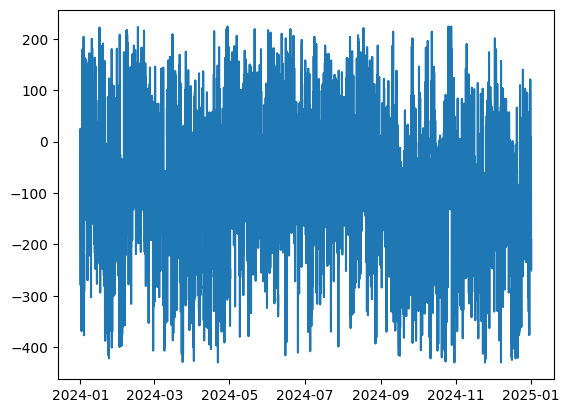

In [11]:
# 1a) Read the CSV, parse Date → DateTimeIndex
df = pd.read_csv(
    "All_data_csv/All_cleared_data.csv",
    parse_dates=["Date"],
    index_col="Date"
)

df = df.drop(columns=['mFRR_DownPurchased', 'mFRR_DownPriceEUR'])
print(df.columns)
print(df.shape)
plt.plot(df.index, df['ImbalanceMWh'])
plt.show()
df_clean = df.copy()

# 2) Find all numeric columns
num_cols = df_clean.select_dtypes(include=[np.number]).columns

# 3) For each numeric column, mask outliers outside the [1%, 99%] quantile
for col in num_cols:
    lo, hi = df_clean[col].quantile([0.01, 0.99])
    mask   = (df_clean[col] < lo) | (df_clean[col] > hi)
    print(f"{col}: masking {mask.sum()} outliers ({mask.mean()*100:.2f}%)")
    df_clean[col] = df_clean[col].mask(mask)  # turn them into NaN

# 4) Interpolate across time for *all* columns at once
df_clean = df_clean.interpolate(method='time', limit_direction='both')

# 5) (Optional) If you want to replace the original
df[num_cols] = df_clean[num_cols]
print(df.shape)
plt.plot(df.index, df['ImbalanceMWh'])
plt.show()

In [12]:
df_input = df
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
print(df.columns)
data_scaled.shape
features = data_scaled
target = data_scaled[:,1]
TimeseriesGenerator(features, target, length=1, sampling_rate=1, batch_size=1)[0]

Index(['ImbalanceMWh', 'ImbalancePriceEUR', 'mFRR_UpPurchased',
       'mFRR_UpPriceEUR', 'SpotPriceEUR', 'FCRdomestic_MW', 'FCRdk_EUR'],
      dtype='object')


(array([[[0.37767584, 0.1596903 , 0.3575    , 0.00249469, 0.10127981,
          0.88888889, 0.43069751]]]),
 array([0.15695621]))

In [13]:
df.head()

,ImbalanceMWh,ImbalancePriceEUR,mFRR_UpPurchased,mFRR_UpPriceEUR,SpotPriceEUR,FCRdomestic_MW,FCRdk_EUR
Date,,,,,,,
2024-01-01 00:00:00,-183.0,55.000000,343.0,0.67,16.990000,9.0,28.7
2024-01-01 01:00:00,-179.0,53.869999,343.0,0.67,28.139999,9.0,28.7
2024-01-01 02:00:00,-30.0,53.869999,343.0,0.67,26.660000,9.0,28.7
2024-01-01 03:00:00,-138.0,4.140000,343.0,0.67,4.140000,9.0,28.7
2024-01-01 04:00:00,-103.0,36.000000,343.0,0.67,-0.030000,9.0,26.1


In [14]:
df.shape

(8784, 7)

In [15]:
bi_weekly_dir_LSTM = split_biweekly_train_test(df)
monthly_dir_LSTM = split_monthly_train_test(df)
quarterly_dir_LSTM = split_quarterly_train_test(df)

Total periods: 26
2024-01-01_to_2024-01-14: Train = 336, Test = 24
2024-01-15_to_2024-01-28: Train = 336, Test = 24
2024-01-29_to_2024-02-11: Train = 336, Test = 24
2024-02-12_to_2024-02-25: Train = 336, Test = 24
2024-02-26_to_2024-03-10: Train = 336, Test = 24
2024-03-11_to_2024-03-24: Train = 336, Test = 24
2024-03-25_to_2024-04-07: Train = 336, Test = 24
2024-04-08_to_2024-04-21: Train = 336, Test = 24
2024-04-22_to_2024-05-05: Train = 336, Test = 24
2024-05-06_to_2024-05-19: Train = 336, Test = 24
2024-05-20_to_2024-06-02: Train = 336, Test = 24
2024-06-03_to_2024-06-16: Train = 336, Test = 24
2024-06-17_to_2024-06-30: Train = 336, Test = 24
2024-07-01_to_2024-07-14: Train = 336, Test = 24
2024-07-15_to_2024-07-28: Train = 336, Test = 24
2024-07-29_to_2024-08-11: Train = 336, Test = 24
2024-08-12_to_2024-08-25: Train = 336, Test = 24
2024-08-26_to_2024-09-08: Train = 336, Test = 24
2024-09-09_to_2024-09-22: Train = 336, Test = 24
2024-09-23_to_2024-10-06: Train = 336, Test = 24
20


=== 2024Q1 ===
6


c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0653
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0573
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0559
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0534
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0524
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0500
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0509
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0505
Epoch 9/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0508
Epoch 10/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0499
Epoch 11/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0487
Epoch 12/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0494
Epoch 13/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0470
Epoch 14/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0458
Epoch 15/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 

c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(24,) (24,)


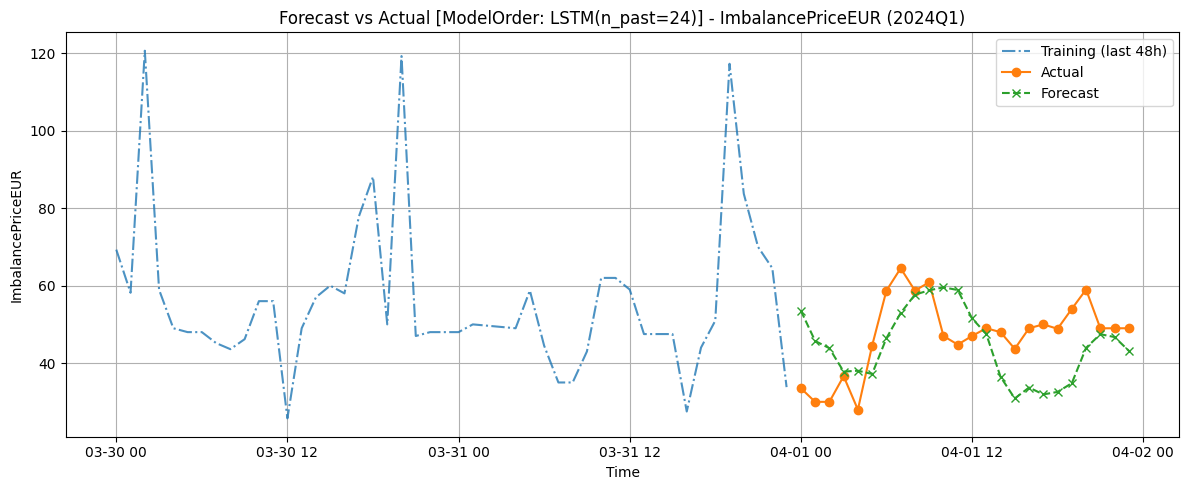


=== 2024Q2 ===
6
Epoch 1/20


c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0920
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0818
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0756
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0696
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0662
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0631
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0630
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0621
Epoch 9/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0624
Epoch 10/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0613
Epoch 11/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0593
Epoch 12/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0597
Epoch 13/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0588
Epoch 14/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0598
Epoch 15/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step 

c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(24,) (24,)


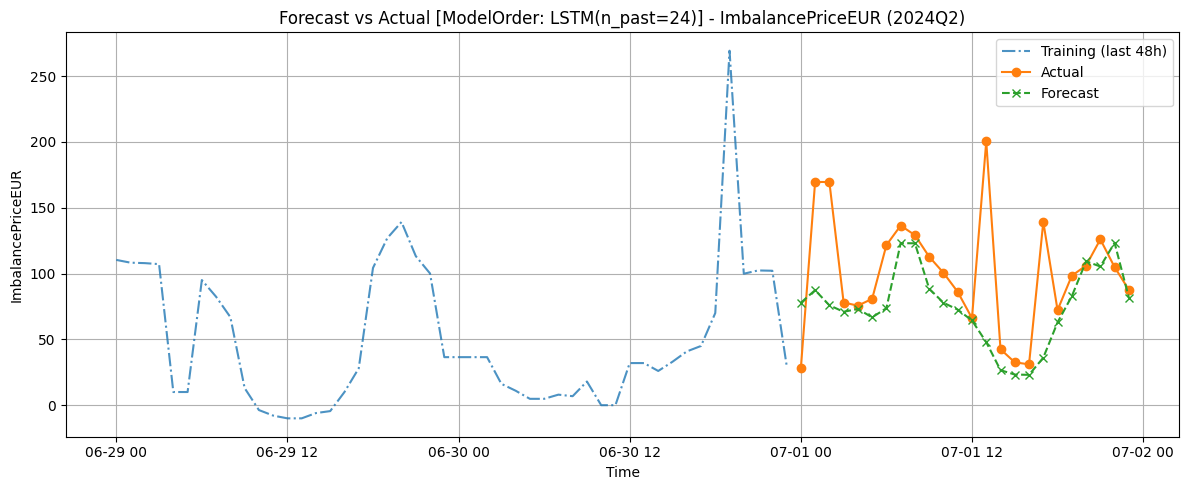


=== 2024Q3 ===
6
Epoch 1/20


c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\zivot\OneDrive - Danmarks Tekniske Universitet\Skrivebord\DTU\Year 3\6th_semester\Thesis_project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1149
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0976
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0883
Epoch 4/20
151/273 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0755

KeyboardInterrupt: 

In [19]:
target_col_LSTM = 'ImbalancePriceEUR'
metrics_quarterly = {}
n_past   = 24
batch_sz = 8

for period, train_df, test_df in zip(
    quarterly_dir_LSTM['period'],
    quarterly_dir_LSTM['train'],
    quarterly_dir_LSTM['test']
):
    print(f"\n=== {period} ===")

    # --- 1) Separate features & target, fit scalers on TRAIN only ---
    feat_cols = [c for c in train_df.columns if c != target_col_LSTM]
    X_tr = train_df[feat_cols].values
    y_tr = train_df[[target_col_LSTM]].values

    scaler_X = MinMaxScaler().fit(X_tr)
    scaler_y = MinMaxScaler().fit(y_tr)

    # scaled train arrays
    X_tr_s = scaler_X.transform(X_tr)
    y_tr_s = scaler_y.transform(y_tr).flatten()

    # --- 2) Build train generator (sliding window) ---
    train_gen = TimeseriesGenerator(
        X_tr_s, y_tr_s,
        length=n_past,
        sampling_rate=1,
        batch_size=batch_sz
    )

    # --- 3) Define & compile your LSTM ---
    num_features = X_tr_s.shape[1]
    print(num_features)
    model = Sequential([
        Input(shape=(n_past, num_features)),
        LSTM(64, return_sequences=True),
        LeakyReLU(alpha = 0.5),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')

    # --- 4) Train on the generator ---
    model.fit(
        train_gen,
        epochs=20,
        verbose=1,
        shuffle=False
    )

    # --- 5) Prepare a prediction generator that starts with the last n_past train rows ---
    X_full  = np.vstack([X_tr_s[-n_past:], scaler_X.transform(test_df[feat_cols])])
    y_dummy = np.concatenate([y_tr_s[-n_past:], scaler_y.transform(test_df[[target_col_LSTM]]).flatten()])

    pred_gen = TimeseriesGenerator(
        X_full, y_dummy,
        length=n_past,
        sampling_rate=1,
        batch_size=1
    )

    # --- 6) Predict & drop the very first item (it corresponds to the last train row) ---
    preds_s = model.predict(pred_gen).flatten()[0:1 + len(test_df)]
    y_pred  = scaler_y.inverse_transform(preds_s.reshape(-1,1)).flatten()
    y_true  = test_df[target_col_LSTM].values
    print(y_true.shape, y_pred.shape)
    # --- 7) Store metrics & plot ---
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = (mean_squared_error(y_true, y_pred))
    metrics_quarterly[period] = {'MAE': mae, 'RMSE': rmse}

    plot_forecast_vs_actual(
        train_df, test_df,
        y_pred,
        column=target_col_LSTM,
        period_label=period,
        model_order=f"LSTM(n_past={n_past})"
    )


MAE
2024Q1     8.682985
2024Q2    26.355343
2024Q3    29.787968
2024Q4    19.118827
Name: MAE, dtype: float64
RMSE
2024Q1    10.199880
2024Q2    46.215339
2024Q3    58.517753
2024Q4    27.755947
Name: RMSE, dtype: float64
20.98628083836492 35.67222950771851


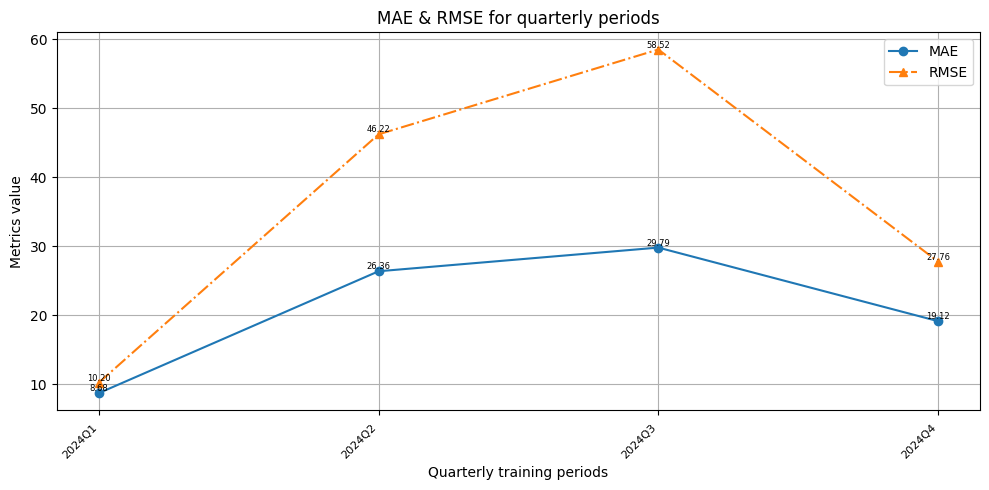

In [18]:
s = pd.DataFrame.from_dict(metrics_quarterly, orient='index')
mae_varbi= s['MAE']
rmse_varbi= np.sqrt(s['RMSE'])
print('MAE')
print(mae_varbi)
print('RMSE')
print(rmse_varbi)
print(np.mean(mae_varbi), np.mean(rmse_varbi))
plt.figure(figsize=(10, 5))
plt.plot(mae_varbi.index, mae_varbi.values,   marker='o', linestyle='-',  label='MAE')
plt.plot(rmse_varbi.index, rmse_varbi.values, marker='^', linestyle='-.', label='RMSE')

for i, (m, r) in enumerate(zip(mae_varbi.values, rmse_varbi.values)):
    plt.text(mae_varbi.index[i],   m, f'{m:.2f}', ha='center', va='bottom', fontsize=6)
    plt.text(rmse_varbi.index[i],  r, f'{r:.2f}', ha='center', va='bottom', fontsize=6)

# Shrink x‐tick labels
plt.xticks(
    rotation=45,
    ha='right',
    fontsize=8,      # make tick labels smaller
    minor=False
)

# If you want to move them a bit away from the axis:
plt.gca().tick_params(axis='x', pad=5)  # increase vertical distance

plt.xlabel('Quarterly training periods')
plt.ylabel('Metrics value')
plt.title('MAE & RMSE for quarterly periods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()